# Denoising filter testing
## required libaries

In [1]:
import os, time, cv2
import numpy as np
import matplotlib.pyplot as plt
import tifffile
from scipy.ndimage import median_filter
from skimage.draw import line as skidline
import functions as f

home_dir = os.path.abspath("")

## load file

In [2]:
#filepath_noisy = filedialog.askopenfilename(title='Please select the image',filetypes=[("Tiff images", "*.tif;*.tiff")])
tiff_file  = home_dir + os.sep + '84d tiff.tif'
CT = f.CTPreprocessor(tiff_file)

Dimensions: z = 1510, h = 1905, w = 1908 [px]


## Show the loaded images

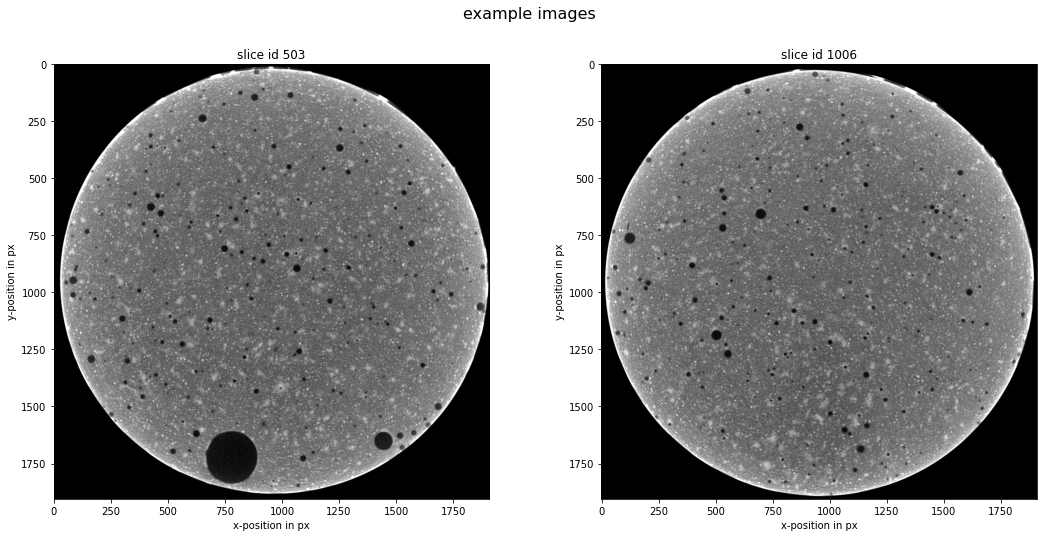

In [3]:
CT.show_example_slices()

## process the main circle, its center point and the inner pores

In [4]:
slice	= CT.select_slice(int(CT.z/3))

CT.identify_main_circle()
CT.get_main_circle()

CT.identify_pores()
CT.remove_pores()

found the center point at (961, 948). The circle has a maximum radius of 947 px.


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

## show images

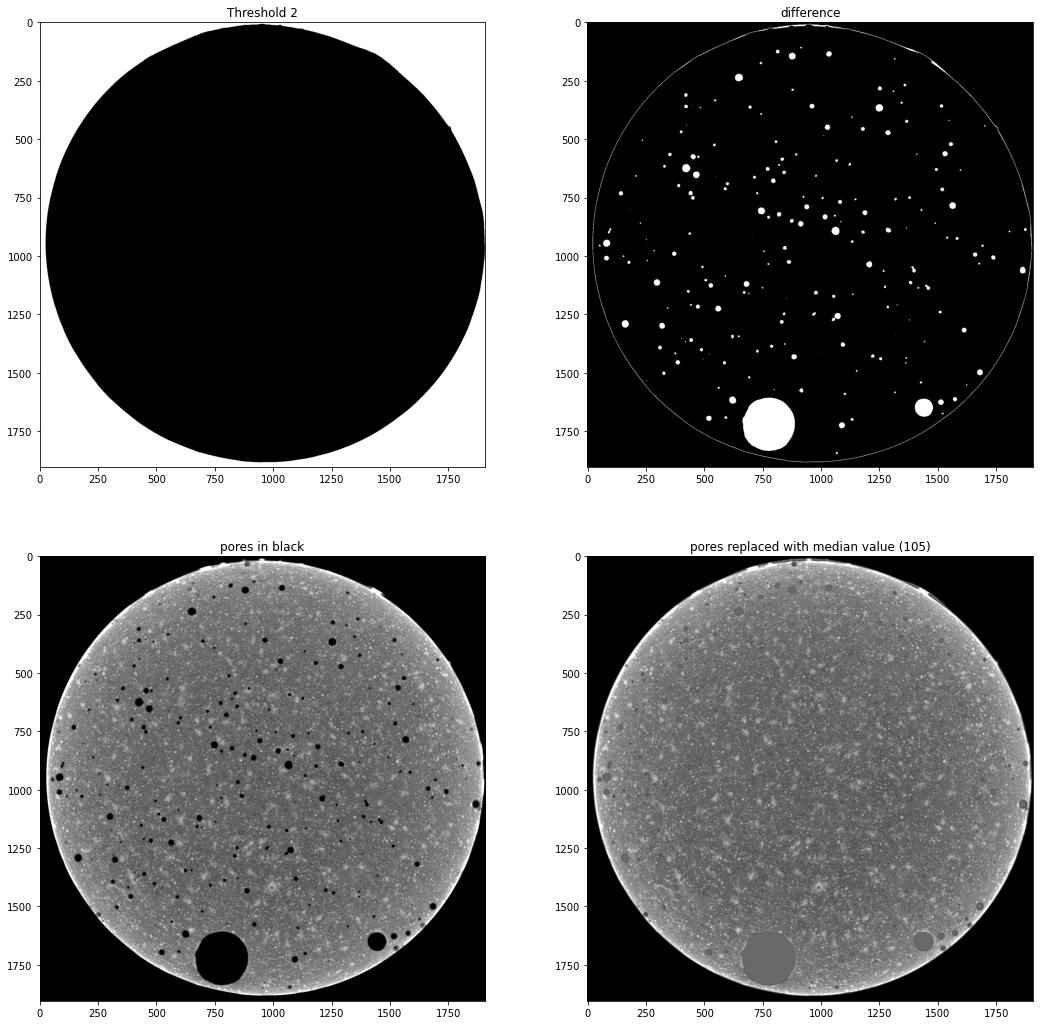

In [5]:
fig, ax = plt.subplots(2, 2, figsize=(18, 18))
#fig.suptitle('raw images', fontsize=16)


ax[0, 0].imshow( CT.main_circle, cmap='gray')
ax[0, 0].set_title( "Threshold 2" )

ax[0, 1].imshow( CT.inner_pores*np.median( CT.slice ), cmap='gray' )
ax[0, 1].set_title( "difference" )

ax[1, 0].imshow( CT.slice * np.logical_not(CT.inner_pores), cmap='gray' )
ax[1, 0].set_title( "pores in black" )

ax[1, 1].imshow( CT.removed_pores , cmap='gray' )
ax[1, 1].set_title( "pores replaced with median value ({:.0f})".format(np.median( CT.slice )) )

plt.show()
print()

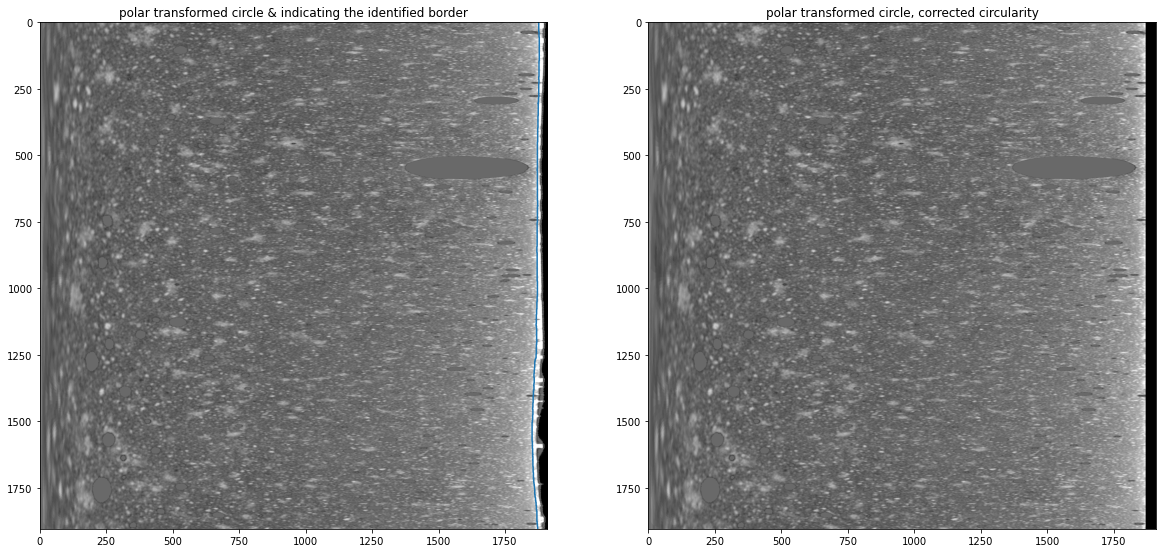

In [6]:
polar_image = CT.circle_to_polar(CT.removed_pores)

border_position, border_deviation = CT.get_border_deviation(polar_image, show_graph = False)
polar_image_corr = CT.correct_circularity( show_result = True )

c + d^( d^( (x-x_0)/b ) )
x_0 = 476.56, b = 358.40, c = 103.27, d = 1.72


e:\GIT\CT_edge_hardening_remover\functions.py:16: RuntimeWarning: overflow encountered in power
  return c + d**(d**((x-x0)/b))


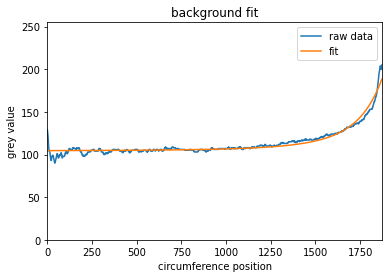

In [7]:
#polar_background, polar_background_fit, background_offset = CT.get_polar_background(polar_image)
polar_background, polar_background_fit, background_offset = CT.get_polar_background(polar_image_corr)

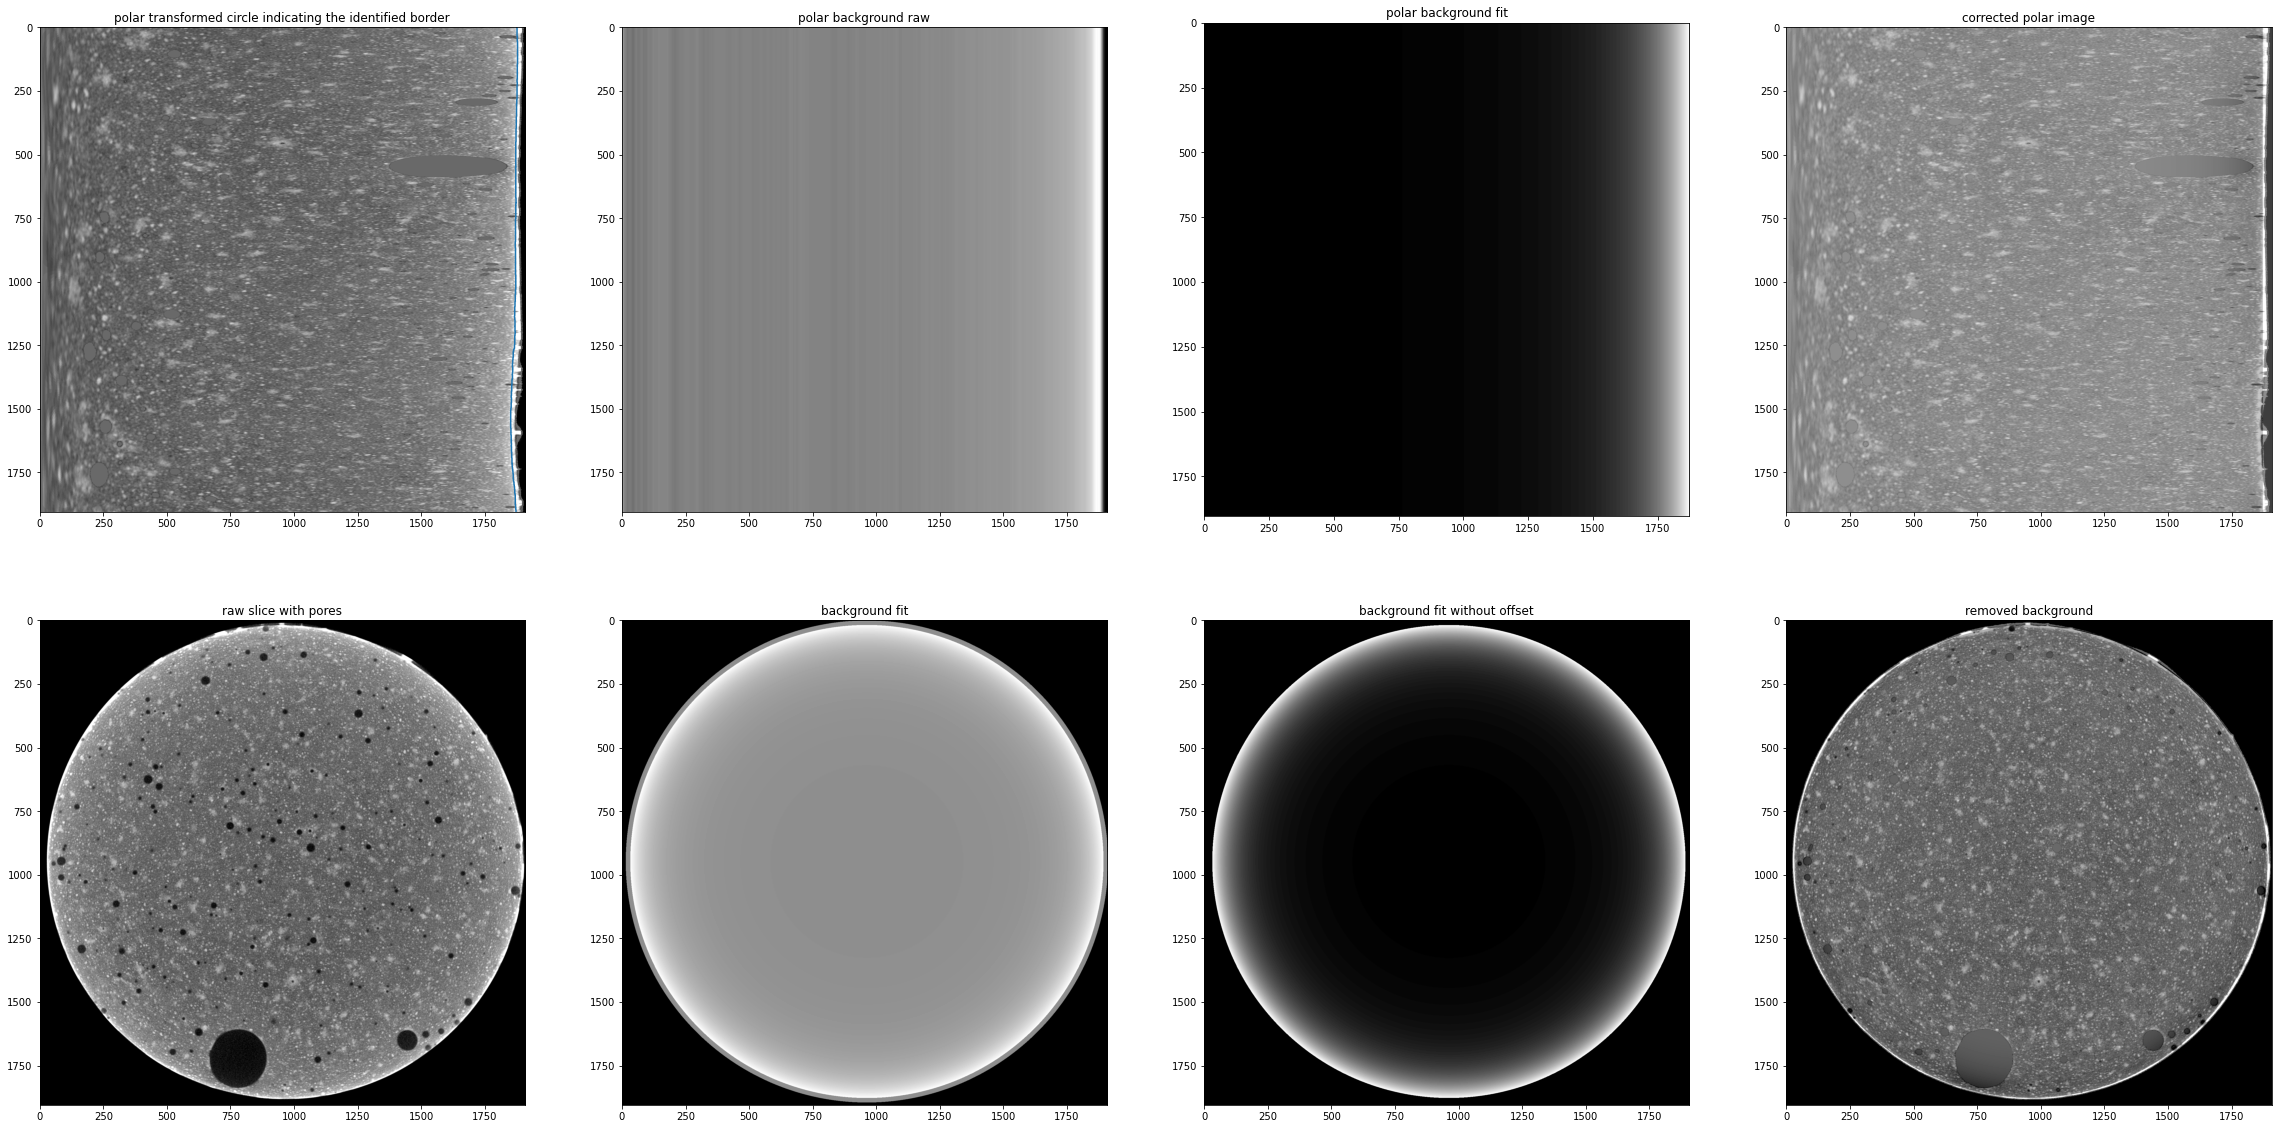

In [8]:
#fixed_image = (polar_image-polar_background_fit)
#unpolar = cv2.linearPolar(fixed_image,(CT.center[0], CT.center[1]), CT.min_length, cv2.WARP_INVERSE_MAP)

fixed_image = (CT.circle_to_polar(slice)-polar_background_fit)
unpolar = cv2.linearPolar(fixed_image,(CT.center[0], CT.center[1]), CT.min_length, cv2.WARP_INVERSE_MAP).clip(min=0)

fig, ax = plt.subplots(2,4, figsize=(40,20))
ax[0,0].imshow( polar_image, cmap='gray' )
ax[0,0].plot( border_position,range(len(border_position)) )
ax[0,0].set_title( "polar transformed circle indicating the identified border" )
ax[0,1].imshow( polar_background, cmap='gray' )
ax[0,1].set_title( "polar background raw" )
ax[0,2].imshow( polar_background_fit[:, 0:CT.border_position], cmap='gray' )
ax[0,2].set_title( "polar background fit" )
ax[0,3].imshow( polar_image-polar_background_fit, cmap='gray' )
ax[0,3].set_title( "corrected polar image" )
ax[1,0].imshow( slice, cmap='gray' )
ax[1,0].set_title( "raw slice with pores" )
ax[1,1].imshow( CT.polar_to_circle( polar_background_fit+background_offset ), cmap='gray' )
ax[1,1].set_title( "background fit" )
ax[1,2].imshow( CT.polar_to_circle( polar_background_fit ), cmap='gray' )
ax[1,2].set_title( "background fit without offset" )
ax[1,3].imshow( unpolar, cmap='gray' )
ax[1,3].set_title( "removed background" )
plt.show()

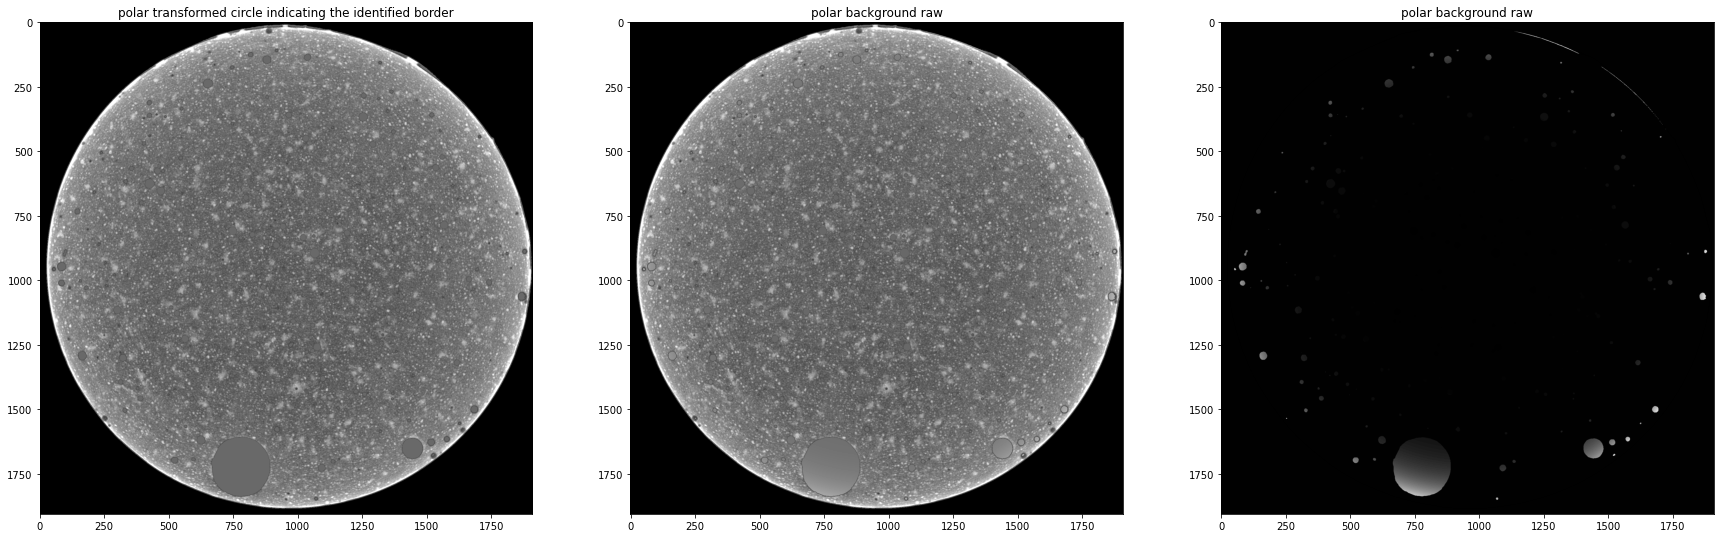

In [9]:

removed_pores2 = CT.slice * np.logical_not(CT.inner_pores) + CT.inner_pores * (CT.polar_to_circle( polar_background_fit+background_offset ))

fig, ax = plt.subplots(1,3, figsize=(30,25))
ax[0].imshow( CT.removed_pores, cmap='gray' )
ax[0].set_title( "polar transformed circle indicating the identified border" )
ax[1].imshow( removed_pores2, cmap='gray' )
ax[1].set_title( "polar background raw" )
ax[2].imshow( removed_pores2-CT.removed_pores, cmap='gray' )
ax[2].set_title( "polar background raw" )
plt.show()

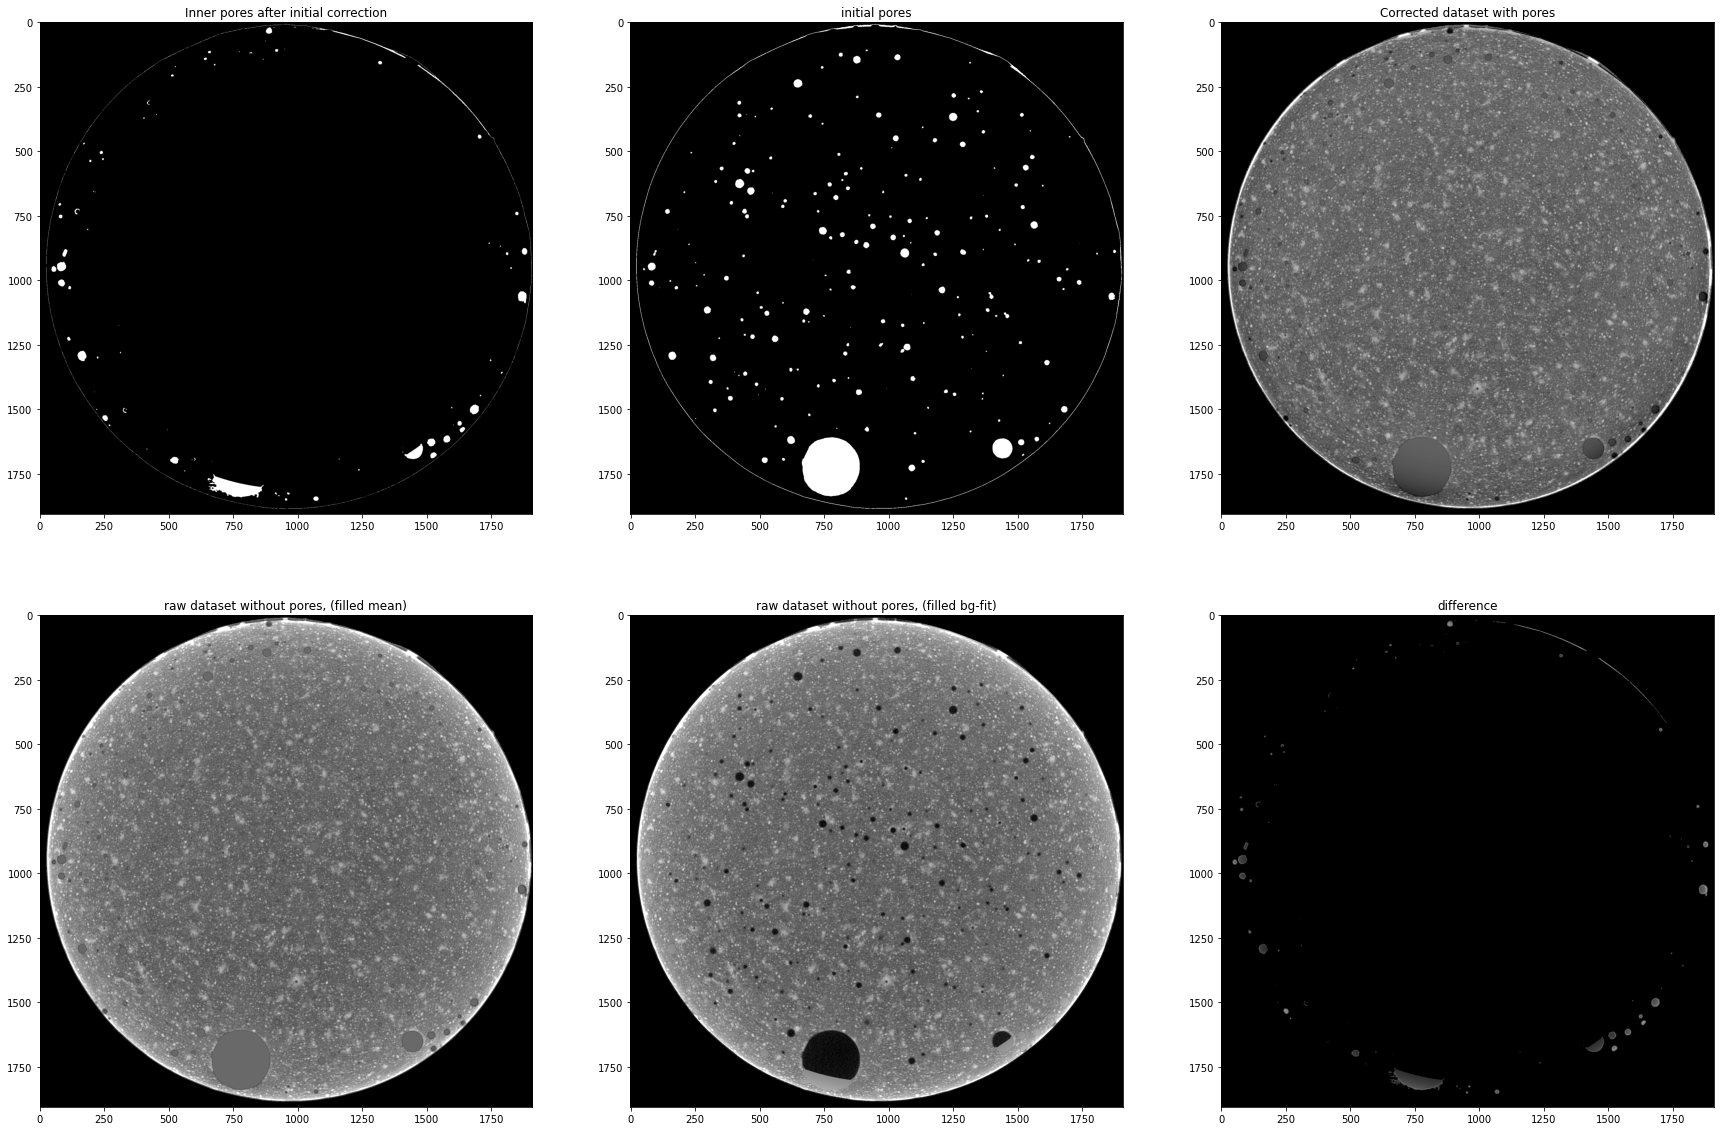

In [10]:
"""
blur = cv2.GaussianBlur( unpolar.astype(np.uint8), (11,11), 0)
inner_pores2 = (np.array(cv2.threshold( blur, 70, 255, cv2.THRESH_BINARY_INV )[1]) - CT.main_circle)/255
#(self.pore_thresh - self.main_circle)/255
removed_pores3 = (CT.slice * np.logical_not(inner_pores2) + inner_pores2 * (CT.polar_to_circle( polar_background_fit+background_offset )))#.astype(np.uint8)


fig, ax = plt.subplots(2,3, figsize=(30,20))
ax[0,0].imshow( inner_pores2, cmap='gray' )
ax[0,0].set_title( "Inner pores after initial correction" )
ax[0,1].imshow( CT.inner_pores, cmap='gray' )
ax[0,1].set_title( "initial pores" )
ax[0,2].imshow( unpolar.astype(np.uint8), cmap='gray' )
ax[0,2].set_title( "Corrected dataset with pores" )
ax[1,0].imshow( CT.removed_pores, cmap='gray' )
ax[1,0].set_title( "raw dataset without pores, (filled mean)" )
ax[1,1].imshow( removed_pores3, cmap='gray' )
ax[1,1].set_title( "raw dataset without pores, (filled bg-fit)" )
ax[1,2].imshow( (removed_pores3-CT.removed_pores).clip(min=0), cmap='gray' )
ax[1,2].set_title( "difference" )
plt.show()
"""

## retry correction

Calculating initial background.
c + d^( d^( (x-x_0)/b ) )
x_0 = 476.56, b = 358.40, c = 103.27, d = 1.72
Iteration #1 of 3
c + d^( d^( (x-x_0)/b ) )
x_0 = 390.82, b = 380.55, c = 102.99, d = 1.72


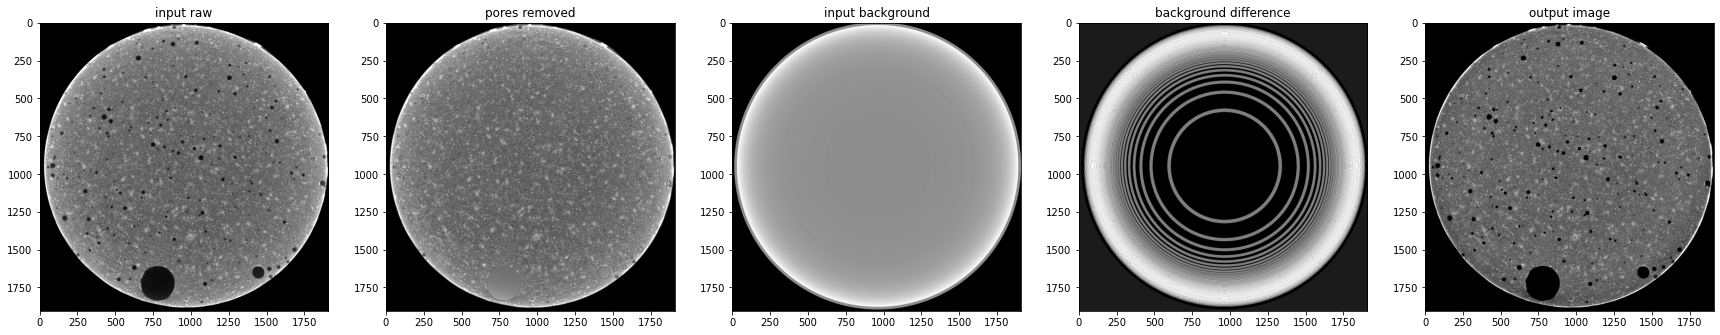

Iteration #2 of 3
c + d^( d^( (x-x_0)/b ) )
x_0 = 384.70, b = 382.14, c = 102.97, d = 1.72


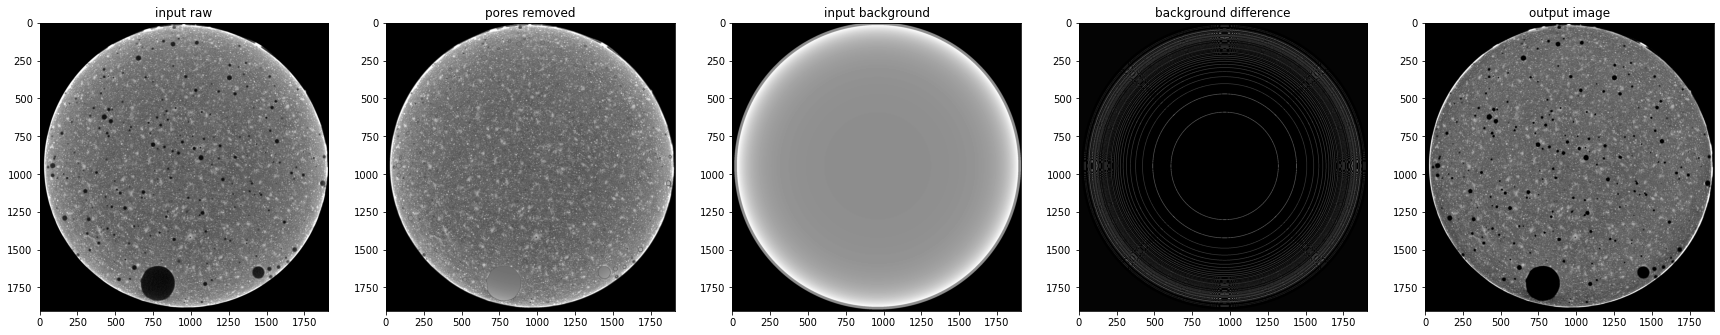

Iteration #3 of 3
c + d^( d^( (x-x_0)/b ) )
x_0 = 383.90, b = 382.35, c = 102.97, d = 1.72


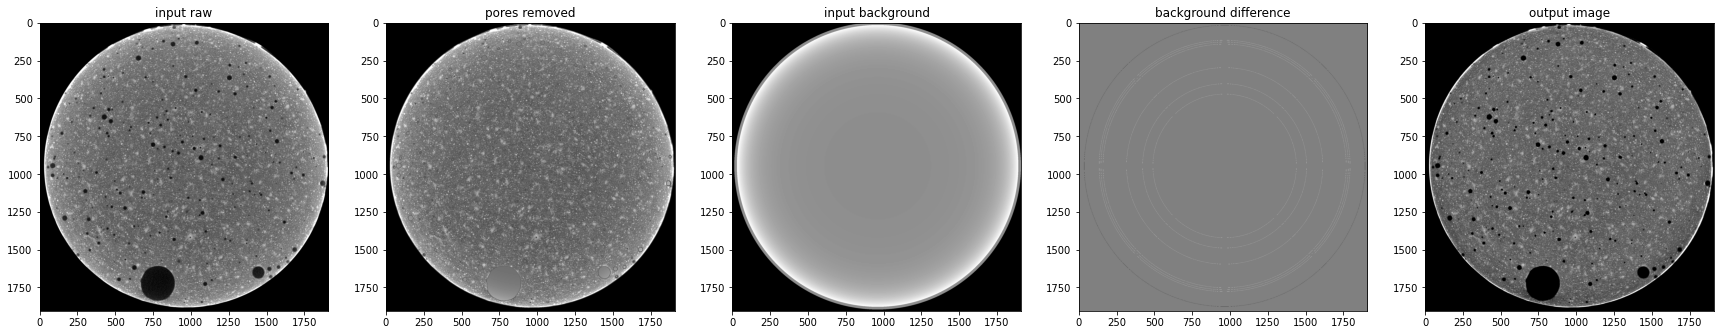

In [11]:
background, fixed = CT.fix_background( iterations= 3, verbose_level = 1 )